In [1]:
# import modules
import math
import numpy as np
import matplotlib.pyplot as plt

## 1. Noise-free data

First, we implement the function `simulate_sir_simple(lam, mu, I_0, T)` function.

In [2]:
# define a function that takes the parameters and simulates the epidemy using the Euler forward scheme to day T
def simulate_sir_simple(lam, mu, I_0, T, visualize=False):
    """
    input:
      lam: the infection rate
      mu: the recovery rate
      I_0: the initial number of infected individuals
    output:
      X: the sequence of the number of additive susceptible individuals and the number of additive recovered individuals
    """
    # define the time step
    dt = 1
    # initialize the vectors for S, I and R
    I = []
    S = []
    R = []
    S_delta = []
    R_delta = []
    # set the initial conditions
    I.append(I_0)
    S.append(1 - I_0)
    R.append(0)
    S_delta.append(0)
    R_delta.append(0)
    # simulate the epidemy
    for t in range(T):
        S.append(S[t] - dt * (lam * S[t] * I[t]))
        I.append(I[t] + dt * (lam * S[t] * I[t] - mu * I[t]))
        R.append(R[t] + dt * (mu * I[t]))
        if t > 0:
            S_delta.append(S[t - 1] - S[t])
            R_delta.append(R[t] - R[t - 1])
    if visualize:
        # return the results
        return [(S[n], I[n], R[n]) for n in range(T + 1)]
    else:
        return [(S_delta[n], R_delta[n]) for n in range(T)]

<div style="color: green; font-weight:bold">Comment</div>
You work with percentages instead of a number of individuals. Also the sample solution header deviates from the one on the exercise sheet. The code, however works the same.

Then we run the simulation and visualize the results.

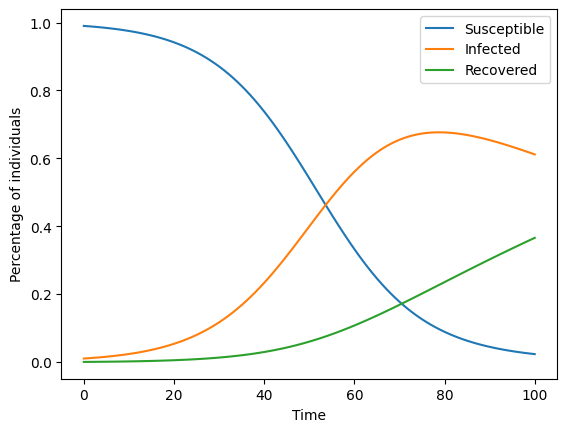

In [3]:
T = 100
# define the parameters
lam = 0.1
mu = 0.01
I_0 = 0.01

# simulate the epidemy
X = simulate_sir_simple(lam, mu, I_0, T, visualize=True)

# visualize the results
plt.figure()
plt.plot(X)
plt.xlabel("Time")
plt.ylabel("Percentage of individuals")
plt.legend(["Susceptible", "Infected", "Recovered"])

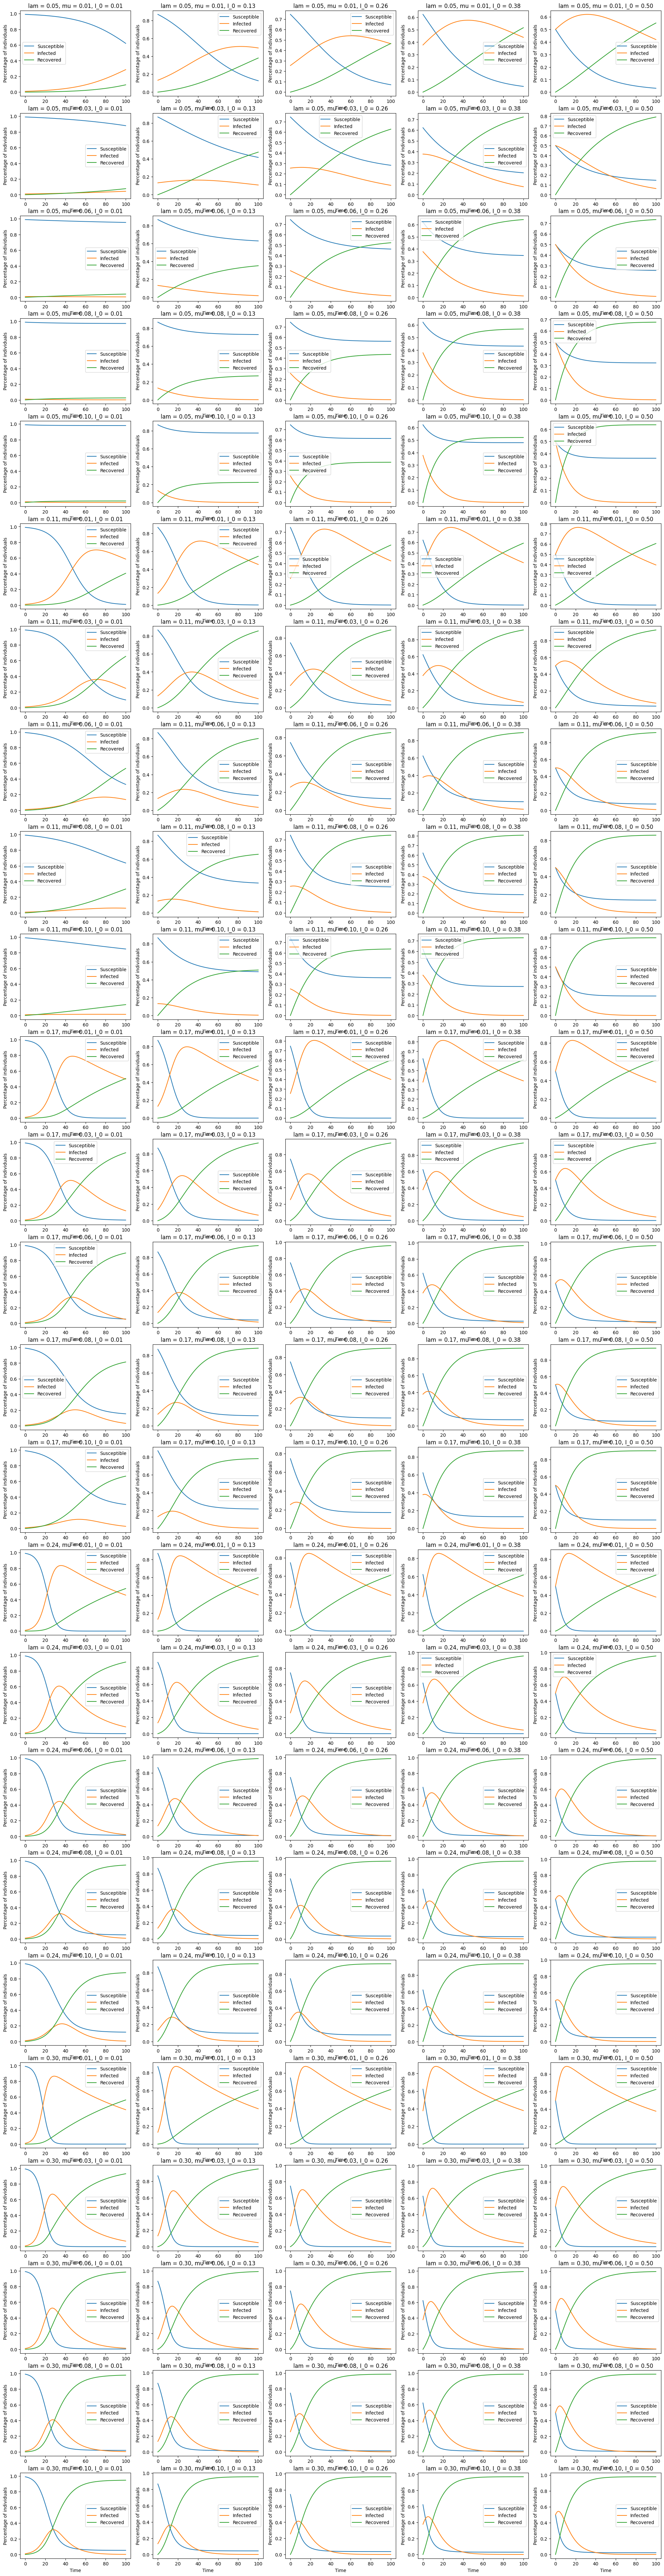

In [4]:
# Determine the suitable range of the parameters
num = 5
# define the parameters
lam = np.linspace(0.05, 0.3, num)
mu = np.linspace(0.01, 0.1, num)
I_0 = np.linspace(0.01, 0.5, num)

fig, axs = plt.subplots(num**2, num, figsize=(25, 20 * num))
for i in range(len(lam)):
    for j in range(len(mu)):
        for k in range(len(I_0)):
            # simulate the epidemy
            X = simulate_sir_simple(lam[i], mu[j], I_0[k], T, visualize=True)
            # visualize the results in a 25*5 figure
            axs[i * num + j, k].plot(X)
            axs[i * num + j, k].set_xlabel("Time")
            axs[i * num + j, k].set_ylabel("Percentage of individuals")
            axs[i * num + j, k].legend(["Susceptible", "Infected", "Recovered"])
            axs[i * num + j, k].set_title(
                "lam = {:.2f}, mu = {:.2f}, I_0 = {:.2f}".format(lam[i], mu[j], I_0[k])
            )

plt.show()

<div style="color: green; font-weight:bold">Comment</div>
Nice prior range testing! Similar to sample solution but with less complex code.

In [5]:
# define simulation prior

import torch
import torch.nn as nn
import torch.optim as optim


def prior(lam_min, lam_max, mu_min, mu_max, I0_min, I0_max):
    """
    input:
      lam_min: the minimum value of the infection rate
      lam_max: the maximum value of the infection rate
      mu_min: the minimum value of the recovery rate
      mu_max: the maximum value of the recovery rate
      I0_min: the minimum value of the initial number of infected individuals
      I0_max: the maximum value of the initial number of infected individuals
    output:
      lam: the infection rate
      mu: the recovery rate
      I_0: the initial number of infected individuals
    """
    # sample the parameters
    lam = np.random.uniform(lam_min, lam_max)
    mu = np.random.uniform(mu_min, mu_max)
    I_0 = np.random.uniform(I0_min, I0_max)
    # return the results
    return lam, mu, I_0

In [6]:
# create the training data
sample_size = 1000
training_set = torch.randn(sample_size, 2, 10, 10)
training_labels = torch.randn(sample_size, 3)
# save X into training set
for i in range(sample_size):
    # sample the parameters
    lam, mu, I_0 = prior(0.05, 0.3, 0.01, 0.1, 0.01, 0.5)
    # simulate the epidemy
    X = simulate_sir_simple(lam, mu, I_0, T)
    # save the results
    training_labels[i, :] = torch.tensor([lam, mu, I_0])
    training_set[i, :, :, :] = torch.tensor(
        [[list(elem)[0] for elem in X], [list(elem)[1] for elem in X]]
    ).view(2, 10, 10)

In [7]:
# create the test data
test_set = torch.randn(sample_size, 2, 10, 10)
test_labels = torch.randn(sample_size, 3)
# save X into test set
for i in range(sample_size):
    # sample the parameters
    lam, mu, I_0 = prior(0.05, 0.3, 0.01, 0.1, 0.01, 0.5)
    # simulate the epidemy
    X = simulate_sir_simple(lam, mu, I_0, T)
    # save the results
    test_labels[i, :] = torch.tensor([lam, mu, I_0])
    test_set[i, :, :, :] = torch.tensor(
        [[list(elem)[0] for elem in X], [list(elem)[1] for elem in X]]
    ).view(2, 10, 10)

In [8]:
print(training_set.shape)

torch.Size([1000, 2, 10, 10])


<div style="color: green; font-weight:bold">Comment</div>
You used a uniform instead of a normal distribution, also the dataset creation is a bit to complex and laborious. Why are you creating sizes 10x10 instead of 100?

In [9]:
class feedforward(nn.Module):
    def __init__(self, input_size=200, output_size=3, hidden_size=1000, layers=5):
        super(feedforward, self).__init__()
        # self.input_size = input_size
        # self.bottleneck_size = bottleneck_size
        # self.hidden_size = hidden_size
        # self.layers = layers
        NN_mod = [
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        ]
        for _ in range(layers):
            NN_mod.append(nn.Linear(hidden_size, hidden_size))
            NN_mod.append(nn.ReLU())
        NN_mod += [nn.Linear(hidden_size, output_size)]
        self.NN = nn.Sequential(*NN_mod)

    def forward(self, x):
        return self.NN(x)

    def fit(self, training_set, training_labels, epochs=100):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for epoch in range(epochs):
            running_loss = 0.0
            for i in range(len(training_set)):
                data = training_set[i]
                inputs = data.float()
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                # print(outputs.shape)
                loss = criterion(outputs, training_labels[i].reshape(outputs.shape))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print("epoch %d, loss %.8f" % (epoch + 1, running_loss / len(training_set)))

In [10]:
model = feedforward()
model.fit(training_set.reshape((sample_size, 1, 200)), training_labels, epochs=20)

epoch 1, loss 0.00730614
epoch 2, loss 0.00289397
epoch 3, loss 0.00165192
epoch 4, loss 0.00080283
epoch 5, loss 0.00067965
epoch 6, loss 0.00062341
epoch 7, loss 0.00068389
epoch 8, loss 0.00052644
epoch 9, loss 0.00054160
epoch 10, loss 0.00057194
epoch 11, loss 0.00051750
epoch 12, loss 0.00048545
epoch 13, loss 0.00051826
epoch 14, loss 0.00042686
epoch 15, loss 0.00042078
epoch 16, loss 0.00043686
epoch 17, loss 0.00040205
epoch 18, loss 0.00038747
epoch 19, loss 0.00037152
epoch 20, loss 0.00037670


In [11]:
# evaluate the model on the test set
criterion = nn.MSELoss()
test_loss = 0.0
for i in range(len(test_set)):
    data = test_set[i]
    inputs = data.float()
    outputs = model.forward(inputs.reshape((1, 1, 200)))
    loss = criterion(outputs, test_labels[i].reshape(outputs.shape))
    test_loss += loss.item()
print("test loss of feed-forward network is: %.8f" % (test_loss / len(test_set)))

test loss of feed-forward network is: 0.00042503


In [12]:
class self_made_CNN(nn.Module):
    def __init__(self, kernel_size=3, output_dim=3):
        super(self_made_CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(2, 16, kernel_size=kernel_size, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 6 * 6, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        # Convolutional layers
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))

        # Flatten before fully connected layers
        # print(x.shape)
        x = x.view(-1, 32 * 6 * 6)

        # Fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)

        return x

    def fit(self, training_set, training_labels, epochs=100):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for epoch in range(epochs):
            running_loss = 0.0
            for i in range(len(training_set)):
                data = training_set[i]
                inputs = data.float()
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                # print(outputs.shape)
                # print(torch.reshape(training_labels[i], outputs.shape))
                loss = criterion(
                    outputs, torch.reshape(training_labels[i], outputs.shape)
                )
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print("epoch %d, loss %.8f" % (epoch + 1, running_loss / len(training_set)))

In [13]:
model_cnn = self_made_CNN()
model_cnn.fit(training_set, training_labels, epochs=20)

epoch 1, loss 0.00596326
epoch 2, loss 0.00207151
epoch 3, loss 0.00142559
epoch 4, loss 0.00109605
epoch 5, loss 0.00089258
epoch 6, loss 0.00078219
epoch 7, loss 0.00065096
epoch 8, loss 0.00061965
epoch 9, loss 0.00059099
epoch 10, loss 0.00050055
epoch 11, loss 0.00050468
epoch 12, loss 0.00041094
epoch 13, loss 0.00042725
epoch 14, loss 0.00033698
epoch 15, loss 0.00029218
epoch 16, loss 0.00026587
epoch 17, loss 0.00026821
epoch 18, loss 0.00022113
epoch 19, loss 0.00019496
epoch 20, loss 0.00026548


In [14]:
# evaluate the model on the test set
def evaluate(model, test_set, test_labels):
    criterion = nn.MSELoss()
    test_loss = 0.0
    for i in range(len(test_set)):
        data = test_set[i]
        inputs = data.float()
        outputs = model.forward(inputs.reshape((1, 2, 10, 10)))
        loss = criterion(outputs, test_labels[i].reshape(outputs.shape))
        test_loss += loss.item()
    print("test loss of CNN is: %.8f" % (test_loss / len(test_set)))
    return test_loss / len(test_set)

Then we need to visualize how the accuracy change as a function of hyperparameters.

In [45]:
# TODO: Choose the best parameters and evaluate it on the test set
# evaluate the CNN model on the test set
evaluate(model_cnn, test_set, test_labels)

test loss of CNN is: 0.00034354


0.0003435427990531252

<div style="color: green; font-weight:bold">Comment</div>
Your model is not as eloquent and advanced as the sample solution. You are missing the the hyperparameter optimazation part. Since you defined your priors as uniform distributions, you missed the plot of the predicted prior locations.

Next, we want to construct two network: summary network $h(X)$ and conditional RealNVP that estimates the posterior $p(Y|h(X))$.

In [75]:
# create a summary network class
class summary_net(nn.Module):
    def __init__(self, kernel_size=3, output_dim=32):
        super(summary_net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(2, 16, kernel_size=kernel_size, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 6 * 6, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        # Convolutional layers
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))

        # Flatten before fully connected layers
        # print(x.shape)
        x = x.view(-1, 32 * 6 * 6)

        # Fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)

        return x


# create a conditional normalizing flow class
class ConditionalRealNVP(nn.Module):
    def __init__(
        self,
        input_size=3,
        hidden_size=1000,
        blocks=5,
        condition_size=32,
        summary_net=None,
    ):
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks  # number of coupling layers
        self.condition_size = condition_size  # number of parameters of the condition
        self.summary_net = summary_net  # a summary network

        self.D_tilde = self.input_size // 2  # dimension of the first half of the input
        # construct the network as summary network
        self.nets = nn.ModuleList(
            nn.Sequential(
                nn.Linear(self.D_tilde + self.condition_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.D_tilde * 2),  # output layer s and t
            )
            for _ in range(self.blocks)
        )

        # construct the orthogonal matrix
        self.shuffle = nn.ModuleList(
            nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks - 1)
        )
        self.shuffle_inverse = nn.ModuleList(
            nn.Linear(self.input_size, self.input_size) for _ in range(self.blocks - 1)
        )
        # initialize the orthogonal matrix using a random orthogonal matrix
        for i in range(self.blocks - 1):
            # generate a random orthogonal matrix
            Q, _ = torch.linalg.qr(torch.randn(self.input_size, self.input_size))
            # set the parameters of the linear layer to the random orthogonal matrix
            self.shuffle[i].weight.data = Q
            self.shuffle[i].bias.data = torch.zeros(self.input_size)
            self.shuffle_inverse[i].weight.data = Q.t()
            self.shuffle_inverse[i].bias.data = torch.zeros(self.input_size)
        # freeze the orthogonal matrix
        for param in self.shuffle.parameters():
            param.requires_grad = False
        for param in self.shuffle_inverse.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        if self.summary_net is not None:
            # use the summary network to get the condition
            y = self.summary_net(y)
        # for the second half of the dimensions rely on the first half
        log_det_J = 0
        for i in range(self.blocks):
            # the first half of the dimensions are not changed
            x_1 = x[:, : self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation
            s, t = torch.chunk(self.nets[i](torch.cat([x_1, y], dim=1)), 2, dim=1)
            # add a affine transformation to the second half of the dimensions
            x_2 = x[:, self.D_tilde :] * torch.exp(torch.tanh(s)) + t
            # combine the first and second half of the dimensions
            x = torch.cat([x_1, x_2], dim=1)
            # update the log determinant of the Jacobian
            log_det_J += torch.sum(torch.tanh(s), dim=1)
            if i != self.blocks - 1:
                # change the dimensions by the random orthogonormal matrix
                x = self.shuffle[i](x)
        return x, log_det_J

    def inverse(self, z, y):
        if self.summary_net is not None:
            # use the summary network to get the condition
            y = self.summary_net(y)
        # for the second half of the dimensions rely on the first half
        for i in range(self.blocks):
            if i != 0:
                # change the dimensions by the inverse of the random orthogonormal matrix
                z = self.shuffle_inverse[self.blocks - 1 - i](z)
            # the first half of the dimensions are not changed
            z_1 = z[:, : self.D_tilde]
            # pass the first half of the dimensions through the network to get the parameters of the affine transformation
            s, t = torch.chunk(
                self.nets[self.blocks - 1 - i](torch.cat([z_1, y], dim=1)), 2, dim=1
            )
            # add a affine transformation to the second half of the dimensions
            z_2 = (z[:, self.D_tilde :] - t) * torch.exp(-torch.tanh(s))
            # combine the first and second half of the dimensions
            z = torch.cat([z_1, z_2], dim=1)
        return z

    def sample(self, num_samples, conditions):
        # sample from a standard normal distribution
        z = torch.randn(num_samples, self.input_size)
        # apply the inverse of the flow
        x = self.inverse(z, conditions)
        return x

In [76]:
# create a function that trains the conditional normalizing flow
def train_CNF(model, theta, conditions, batch_size, epochs=20, visualize=False):
    # define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    dataset = list(zip(theta, conditions))

    # initialize the weights
    for param in model.parameters():
        if param.dim() > 1:
            nn.init.xavier_uniform_(param)
    # initialize the loss history
    loss_history = []
    # train the model
    for epoch in range(epochs):
        running_loss = 0.0
        # shuffle the dataset
        np.random.shuffle(dataset)
        for i in range(len(dataset) // batch_size):
            # get the current batch
            batch = dataset[i * batch_size : (i + 1) * batch_size]
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = zip(*batch)
            inputs = torch.stack(inputs)
            labels = torch.stack(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs, log_det_J = model(inputs, labels)
            loss = -torch.mean(
                torch.sum(-0.5 * outputs**2, dim=1) - log_det_J
            )  # negative log-likelihood
            loss.backward(retain_graph=True)
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        loss_history.append(running_loss / (len(dataset) // batch_size))
        print(
            "epoch %d, loss %.8f"
            % (epoch + 1, running_loss / (len(dataset) // batch_size))
        )
    if visualize:
        # visualize the loss function
        plt.figure()
        plt.plot(loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

epoch 1, loss -4.79138273
epoch 2, loss -4.99972784
epoch 3, loss -4.99991492
epoch 4, loss -4.99992914
epoch 5, loss -4.99992981
epoch 6, loss -4.99992584
epoch 7, loss -4.99991244
epoch 8, loss -4.99991608
epoch 9, loss -4.99994143
epoch 10, loss -4.99997114
epoch 11, loss -4.99997406
epoch 12, loss -4.99996137
epoch 13, loss -4.99998371
epoch 14, loss -4.99998588
epoch 15, loss -4.99998280
epoch 16, loss -4.99998267
epoch 17, loss -4.99998675
epoch 18, loss -4.99998998
epoch 19, loss -4.99998524
epoch 20, loss -4.99998115


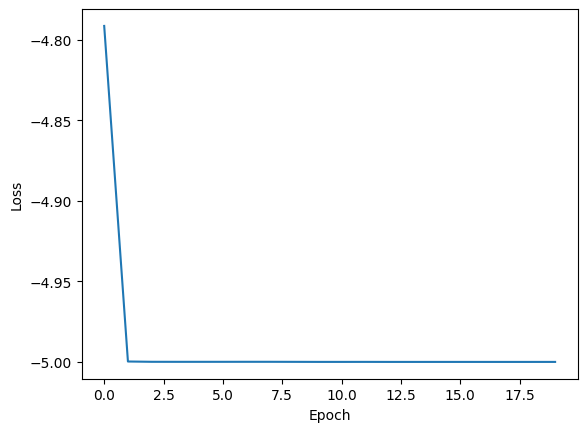

In [77]:
# train the conditional normalizing flow
model_cnf = ConditionalRealNVP(
    condition_size=200, summary_net=summary_net(output_dim=200)
)

# sample from the prior
sample_size = 6000
theta_set = torch.randn(sample_size, 3)
observations = torch.randn(sample_size, 2, 10, 10)
for i in range(sample_size):
    # sample the parameters
    lam, mu, I_0 = prior(0.05, 0.3, 0.01, 0.1, 0.01, 0.5)
    # simulate the epidemy
    X = simulate_sir_simple(lam, mu, I_0, T)
    # save the results
    theta_set[i, :] = torch.tensor([lam, mu, I_0])
    observations[i, :, :, :] = torch.tensor(
        [[list(elem)[0] for elem in X], [list(elem)[1] for elem in X]]
    ).view(2, 10, 10)

train_CNF(
    model_cnf,
    theta_set,
    observations.view(-1, 2, 10, 10),
    batch_size=128,
    epochs=20,
    visualize=True,
)

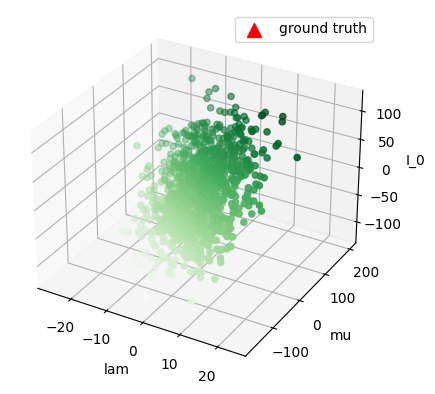

In [78]:
# set the ground truth distribution
lam_gt = 0.2
mu_gt = 0.05
I_0_gt = 0.2
# sample from the ground truth distribution
X_gt = simulate_sir_simple(lam_gt, mu_gt, I_0_gt, T)

# sample 1000 times from the prior
n_prior = 1000
theta_prior = torch.zeros(n_prior, 3)
for i in range(n_prior):
    theta_prior[i, :] = torch.tensor(prior(0.05, 0.3, 0.01, 0.1, 0.01, 0.5))

# duplicate the observations by the number of samples from the prior
conditions = (
    torch.tensor([[list(elem)[0] for elem in X_gt], [list(elem)[1] for elem in X_gt]])
    .view(1, 2, 10, 10)
    .repeat(n_prior, 1, 1, 1)
)

posterior = model_cnf.sample(n_prior, conditions).detach().numpy()

# visualize the posterior in 3D
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(
    posterior[:, 0], posterior[:, 1], posterior[:, 2], c=posterior[:, 2], cmap="Greens"
)
ax.set_xlabel("lam")
ax.set_ylabel("mu")
ax.set_zlabel("I_0")
# signifying the ground truth
ax.scatter3D(lam_gt, mu_gt, I_0_gt, c="r", marker="^", s=100, label="ground truth")
ax.legend()
plt.show()

<div style="color: green; font-weight:bold">Comment</div>
Your model is implemented incorrectly, the loss is not decreasing at all. Look at your RealNVP implementation!

<div style="color: green; font-weight:bold">Comment</div>
All other tasks from 1.5 upwards unfortunatly missing